In [1]:
!pip install xlrd
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 16.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.2 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [4]:
import sys
import os
import pandas as pd
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from google.colab import drive
from numpy import mean
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.constraints import MaxNorm
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import KerasClassifier
from sklearn.metrics import classification_report

tf.compat.v1.disable_eager_execution()

drive.mount('/content/drive', force_remount=True)
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/'

dataset = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/UNSW_NB15_MIA.csv")
dataset = dataset.dropna()

dataset = dataset.drop(['sport', 'dsport', 'stcpb', 'dtcpb', 'Stime', 'Ltime', 'sbytes', 'dbytes', 'Sload', 'Dload'], axis=1)
dataset['proto'] = pd.Categorical(dataset['proto']).codes
dataset['state'] = pd.Categorical(dataset['state']).codes
dataset['service'] = pd.Categorical(dataset['service']).codes
dataset['attack_cat'] = pd.Categorical(dataset['attack_cat']).codes
ATTACK_CAT_MAP = {1:0,2:1,3:2,4:3, 5:4,6:5,7:6,8:7}
dataset['attack_cat'] = dataset['attack_cat'].replace(ATTACK_CAT_MAP)
print(len(dataset.query("attack_cat == 0")))
print(len(dataset.query("attack_cat == 1")))
print(len(dataset.query("attack_cat == 2")))
print(len(dataset.query("attack_cat == 3")))
print(len(dataset.query("attack_cat == 4")))
print(len(dataset.query("attack_cat == 5")))
print(len(dataset.query("attack_cat == 6")))
print(len(dataset.query("attack_cat == 7")))

Mounted at /content/drive
572
8
284
4099
7175
226
17
20096


In [ ]:
sm_dataset_0 = dataset.query("attack_cat == 0").iloc[1:28000]
sm_dataset_1 = dataset.query("attack_cat == 1").iloc[1:28000]
sm_dataset_2 = dataset.query("attack_cat == 2").iloc[1:28000]
sm_dataset_3 = dataset.query("attack_cat == 3").iloc[1:28000]
sm_dataset_4 = dataset.query("attack_cat == 4").iloc[1:28000]
sm_dataset_5 = dataset.query("attack_cat == 5").iloc[1:28000]
sm_dataset_6 = dataset.query("attack_cat == 6").iloc[1:28000]
sm_dataset_7 = dataset.query("attack_cat == 7").iloc[1:28000]
sm_dataset = pd.concat([sm_dataset_0, sm_dataset_1, sm_dataset_2, sm_dataset_3, sm_dataset_4,sm_dataset_5,sm_dataset_6,sm_dataset_7])
print(len(sm_dataset_0))
print(len(sm_dataset_1))
print(len(sm_dataset_2))
print(len(sm_dataset_3))
print(len(sm_dataset_4))
print(len(sm_dataset_5))
print(len(sm_dataset_6))
print(len(sm_dataset_7))
sm_dataset.head()

571
7
283
4098
7174
225
16
20095


,proto,state,dur,sttl,dttl,sloss,dloss,service,Spkts,Dpkts,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat
167,0,1,0.388297,254,252,2,1,4,10,8,...,0,0,12,11,3,3,3,1,3,0
168,0,1,0.180398,254,252,2,1,4,10,6,...,0,0,12,11,3,3,3,1,3,0
169,0,1,0.175691,254,252,2,1,4,10,6,...,0,0,12,11,2,3,3,1,2,0
171,0,1,0.432149,254,252,2,1,4,10,8,...,0,0,12,11,2,3,3,1,2,0
173,0,1,0.163739,254,252,2,1,4,10,6,...,0,0,12,11,3,3,3,1,3,0


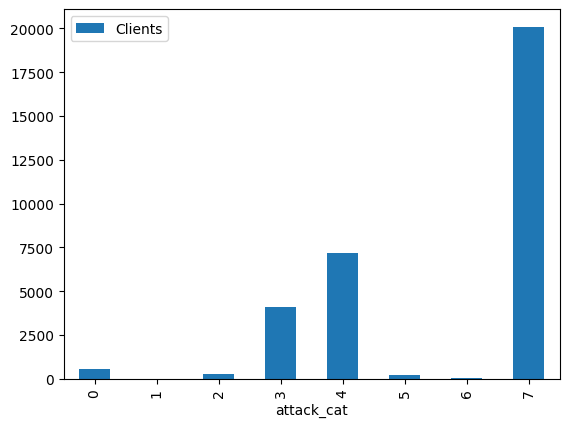

In [ ]:
data = {
  "attack_cat": [0,1,2,3,4,5,6,7],
  "Clients": [len(sm_dataset.query("attack_cat == 0")),
              len(sm_dataset.query("attack_cat == 1")),
              len(sm_dataset.query("attack_cat == 2")),
              len(sm_dataset.query("attack_cat == 3")),
              len(sm_dataset.query("attack_cat == 4")),
              len(sm_dataset.query("attack_cat == 5")),
              len(sm_dataset.query("attack_cat == 6")),
              len(sm_dataset.query("attack_cat == 7"))
              ]
}

#load data into a DataFrame object:
df = pd.DataFrame(data)

df.plot(kind = 'bar', x='attack_cat',y = 'Clients')
plt.show()


In [ ]:
X_orig = sm_dataset.to_numpy()
X_orig.shape
#X_orig

(20373, 34)

In [ ]:
"""Python implementation of SMOTE.
This implementation is based on the original variant of SMOTE.
Original paper: https://www.jair.org/media/953/live-953-2037-jair.pdf
"""
class PPSMOTE:

    def __init__(self, ratio=100, k_neighbors=2, random_state=None):
        if ratio > 0 and ratio < 100:
            self.ratio = ratio
        elif ratio >= 100:
            if ratio % 100 == 0:
                self.ratio = ratio
            else:
                raise ValueError(
                    'ratio over 100 should be multiples of 100')
        else:
            raise ValueError(
                'ratio should be greater than 0')

        if type(k_neighbors) == int:
            if k_neighbors > 0:
                self.k_neighbors = k_neighbors
            else:
                raise ValueError(
                    'k_neighbors should be integer greater than 0')
        else:
            raise TypeError(
                'Expect integer for k_neighbors')

        if type(random_state) == int:
            np.random.seed(random_state)

    def _laplaceNoise(self, mu, b, size):
        return np.random.laplace(mu, b, size)

    def _randomize(self, samples, ratio):
        length = samples.shape[0]
        target_size = length * ratio
        idx = np.random.randint(length, size=target_size)

        return samples[idx, :]

    def _populate(self, idx, nnarray):
        noise = self._laplaceNoise(0.5, 0.0125, 34)

        for i in range(self.N):
            nn = np.random.randint(low=0, high=self.k_neighbors)
            for attr in range(self.numattrs):
                dif = (self.samples[nnarray[nn]][attr] - self.samples[idx][attr])
                #gap = np.random.uniform()
                self.synthetic[self.newidx][attr] = (self.samples[idx][attr] + noise[attr] * dif)
            self.newidx += 1

    def oversample(self, samples, merge=False):

        if type(samples) == list:
            self.samples = np.array(samples)
        elif type(samples) == np.ndarray:
            self.samples = samples
        else:
            raise TypeError(
                'Expect a built-in list or an ndarray for samples')

        self.numattrs = self.samples.shape[1]

        if self.ratio < 100:
            ratio = ratio / 100.0
            self.samples = self._randomize(self.samples, ratio)
            self.ratio = 100

        self.N = int(self.ratio / 100)
        new_shape = (self.samples.shape[0] * self.N, self.samples.shape[1])
        self.synthetic = np.empty(shape=new_shape)
        self.newidx = 0

        self.nbrs = NearestNeighbors(n_neighbors=self.k_neighbors)
        self.nbrs.fit(samples)
        self.knn = self.nbrs.kneighbors()[1]

        for idx in range(self.samples.shape[0]):
            nnarray = self.knn[idx]
            self._populate(idx, nnarray)

        if merge:
            return np.concatenate((self.samples, self.synthetic))
        else:
            return self.synthetic
smt = PPSMOTE(ratio=100, k_neighbors=10)
synthetic_samples = smt.oversample(sm_dataset_0.to_numpy())
pp_sm_dataset = smt.oversample(sm_dataset_0.to_numpy(), merge=True)
sm_dataset_0=pd.DataFrame(pp_sm_dataset)
pp_sm_dataset.shape


(36544, 34)

In [ ]:
X_train_1 = sm_dataset_0.to_numpy()[1:20000,:]
X_train_2 = sm_dataset_1.to_numpy()[1:20000,:]
X_train_3 = sm_dataset_2.to_numpy()[1:20000,:]
X_train_4 = sm_dataset_3.to_numpy()[1:20000,:]
X_train_51 = sm_dataset_4.to_numpy()[1:20000,:]
X_train_6 = sm_dataset_5.to_numpy()[1:20000,:]
X_train_7 = sm_dataset_6.to_numpy()[1:20000,:]
X_train_8 = sm_dataset_7.to_numpy()[1:20000,:]
X_train_5 =np.concatenate((X_train_1,X_train_2,X_train_3,X_train_4,X_train_51,X_train_6,X_train_7,X_train_8),axis=0)
X_train_5.shape
print(len(sm_dataset_0))
print(len(sm_dataset_1))
print(len(sm_dataset_2))
print(len(sm_dataset_3))
print(len(sm_dataset_4))
print(len(sm_dataset_5))
print(len(sm_dataset_6))
print(len(sm_dataset_7))
np.unique(X_train_5[:,-1])

36544
28672
36224
32784
114784
28800
32768
20095


array([0., 1., 2., 3., 4., 5., 6., 7.])

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(X_train_5)
core_samples_mask = dbscan.core_sample_indices_
labels = dbscan.labels_
inlier_indices = np.where(labels != -1)[0]
outlier_indices = np.where(labels == -1)[0]
inlier_data = X_train_5[inlier_indices]
outlier_data = X_train_5[outlier_indices]
X_train_5 = inlier_data

In [ ]:
#X_train_5[:,:33].shape
np.unique(X_train_5[:,-1])

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [ ]:
#smt = SMOTE()
#smt = ADASYN()
#smt = BorderlineSMOTE(random_state = 42, kind = 'borderline-1')
smt = SMOTEENN(random_state=42)
#smt = SMOTETomek(random_state = 42)
#smt = SVMSMOTE(random_state = 42)
#smt = KMeansSMOTE(random_state=42)
X = X_train_5[:,:33]
y = X_train_5[:,-1]

X_train_5, y_train_5 = smt.fit_resample(X, y)
np.unique(y_train_5)
X_train_5[:,:33].shape

(138834, 33)

In [ ]:
def _splitData(X_train_5):
  X_train, X_test, y_train, y_test = train_test_split(X_train_5[:,:33],X_train_5[:,-1], random_state=104,test_size=0.5,shuffle=True)
  #X_train, X_test, y_train, y_test = train_test_split(X_train_5,y_train_5, random_state=104,test_size=0.5,shuffle=True)
  scaler = MinMaxScaler()
  label_encoder = LabelEncoder()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.fit_transform(X_test)
  label_encoder.fit(y_train)
  label_encoder.fit(y_test)
  y_train = label_encoder.transform(y_train)
  y_test = label_encoder.transform(y_test)
  return X_train, X_test, y_train, y_test

def _buildModel(X_train, X_test, y_train, y_test):
  #os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
  loss = tf.keras.losses.SparseCategoricalCrossentropy()

  model = Sequential()
  model.add(Dense(33, activation='relu', input_dim=33, kernel_constraint=MaxNorm(3)))
  model.add(Dropout(0.3))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(8, activation='softmax'))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  #model.summary()
  history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=128,
                        epochs=30,
                        verbose=0)
  pred_val = model.predict(X_test)
  #fpr, tpr, threshold = roc_curve(y_test, pred_val, pos_label=1)
  #random_pred_val = [0 for i in range(len(y_test))]
  #p_fpr1, p_tpr1, _ = roc_curve(y_test, random_pred_val, pos_label=1)
  auc_score = roc_auc_score(y_test, pred_val, multi_class='ovr')
  print(f"AUC SCORE: {auc_score:6f}")
  return model, auc_score

def calc_precision_recall(predicted, actual, positive_value=1):
    score = 0  # both predicted and actual are positive
    num_positive_predicted = 0  # predicted positive
    num_positive_actual = 0  # actual positive
    for i in range(len(predicted)):
        if predicted[i] == positive_value:
            num_positive_predicted += 1
        if actual[i] == positive_value:
            num_positive_actual += 1
        if predicted[i] == actual[i]:
            if predicted[i] == positive_value:
                score += 1

    if num_positive_predicted == 0:
        precision = 1
    else:
        precision = score / num_positive_predicted  # the fraction of predicted “Yes” responses that are correct
    if num_positive_actual == 0:
        recall = 1
    else:
        recall = score / num_positive_actual  # the fraction of “Yes” responses that are predicted correctly
    return precision, recall

def _attackMIA(X_train, X_test, y_train, y_test, model):
  attack_train_ratio = 0.5
  attack_train_size = int(len(X_train) * attack_train_ratio)
  attack_test_size = int(len(X_test) * attack_train_ratio)

  mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))

  mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')

  mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32),y_train[:attack_train_size].astype(np.float32),
                    X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
  mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
  mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])

  mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
  mlp_test_acc_bb = 1-(np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
  mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))

  #print(f"Members Accuracy: {mlp_train_acc_bb:.4f}")
  #print(f"Non Members Accuracy {mlp_test_acc_bb:.4f}")
  #print(f"Attack Accuracy {mlp_acc_bb:.4f}")

  precision, recall = calc_precision_recall(np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb)),
                              np.concatenate((np.ones(len(mlp_inferred_train_bb)), np.zeros(len(mlp_inferred_test_bb)))))
  y_train_pred = np.concatenate((mlp_inferred_train_bb, mlp_inferred_test_bb))
  y_train_true = np.concatenate((np.ones_like(mlp_inferred_train_bb), np.zeros_like(mlp_inferred_test_bb)))
  #print(classification_report(y_pred=y_train_pred, y_true=y_train_true))
  return mlp_train_acc_bb, mlp_test_acc_bb, mlp_acc_bb, precision, recall


In [ ]:
import concurrent.futures
import threading

num_iterations = 20
auc = []
member  = []
nonmember = []
att = []
prec = []
rec = []

def execAttack(lock):
  with lock:
    #print("Attack executed.")
    X_train, X_test, y_train, y_test = _splitData(X_train_5)
    model, auc_score = _buildModel(X_train, X_test, y_train, y_test)
    mlp_train_acc_bb, mlp_test_acc_bb, mlp_acc_bb, precision, recall = _attackMIA(X_train, X_test, y_train, y_test, model)
    #print(f"AUC SCORE,Members Accuracy,Non Members Accuracy,Attack Accuracy,Attack Precision,Attack Recall")
    print(f"{auc_score:4f},{mlp_train_acc_bb:4f},{mlp_test_acc_bb:4f},{mlp_acc_bb:4f},{precision:4f},{recall:4f}")
    auc.append(auc_score)
    member.append(mlp_train_acc_bb)
    nonmember.append(mlp_test_acc_bb)
    att.append(mlp_acc_bb)
    prec.append(precision)
    rec.append(recall)

with concurrent.futures.ThreadPoolExecutor() as executor:
    lock = threading.Lock()
    futures = [executor.submit(execAttack,lock) for _ in range(num_iterations)]
    concurrent.futures.wait(futures)
ppldf = pd.DataFrame()
ppldf['AUC'] = np.array(auc)
ppldf['Member_Accuracy'] = np.array(member)
ppldf['Non_Member_Accuracy'] = np.array(nonmember)
ppldf['Attack_accuracy'] = np.array(att)
ppldf['Precision'] = np.array(prec)
ppldf['Recall'] = np.array(rec)
#ppldf.head()
ppldf.to_csv("/content/drive/MyDrive/Colab Notebooks/results/Classes_8/result_8c_80.csv")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992211
0.992211,0.651233,0.649907,0.650570,0.650371,0.651233


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992221
0.992221,0.669758,0.638607,0.654183,0.649525,0.669758


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992018
0.992018,0.639757,0.644332,0.642045,0.642697,0.639757


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992565
0.992565,0.675859,0.690885,0.683372,0.686169,0.675859


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.991489
0.991489,0.627756,0.708635,0.668196,0.682996,0.627756


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992283
0.992283,0.599855,0.667408,0.633632,0.643313,0.599855


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.991964
0.991964,0.656208,0.652883,0.654545,0.654033,0.656208


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.989355
0.989355,0.666658,0.662358,0.664508,0.663804,0.666658


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992775
0.992775,0.668333,0.667283,0.667808,0.667632,0.668333


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992250
0.992250,0.616931,0.666508,0.641720,0.649112,0.616931


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.991994
0.991994,0.642532,0.682084,0.662308,0.668992,0.642532


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992743
0.992743,0.653208,0.675134,0.664171,0.667851,0.653208


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.991812
0.991812,0.692460,0.618556,0.655508,0.644806,0.692460


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.993039
0.993039,0.678309,0.693010,0.685659,0.688429,0.678309


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992357
0.992357,0.651633,0.651383,0.651508,0.651470,0.651633


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992971
0.992971,0.648257,0.663033,0.655645,0.657980,0.648257


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992858
0.992858,0.642307,0.706635,0.674471,0.686466,0.642307


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992822
0.992822,0.703435,0.671109,0.687272,0.681408,0.703435


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992749
0.992749,0.688509,0.663783,0.676146,0.671896,0.688509


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


AUC SCORE: 0.992012
0.992012,0.653008,0.638907,0.645957,0.643928,0.653008


In [ ]:
import numpy as np
import math

_data = X_orig

l1_norm_sensitivity = 0

for i, data_point in enumerate(_data):
    temp_dataset = np.delete(_data, i, axis=0)

    l1_norm_orig = np.linalg.norm(_data, ord=1)
    l1_norm_temp = np.linalg.norm(temp_dataset, ord=1)

    diff = abs(l1_norm_orig - l1_norm_temp)
    #print(diff)
    l1_norm_sensitivity = max(l1_norm_sensitivity, diff)

print("L1 Norm Sensitivity:",l1_norm_sensitivity)


L1 Norm Sensitivity: 848435.1736000031


In [ ]:
import numpy as np

# Set the parameters
mean_value = 0.2
scale_value = 0.05
sample_size = 34

# Generate a sample from Laplace distribution
laplace_sample = np.random.laplace(loc=mean_value, scale=scale_value, size=sample_size)

# Display the generated sample
print("Generated Laplace Sample:")
print(laplace_sample)


Generated Laplace Sample:
[0.1519572  0.07657064 0.22954775 0.18617515 0.22539074 0.13392675
 0.26448441 0.18159076 0.2069173  0.20801243 0.24221986 0.23175183
 0.17020946 0.21151952 0.32228759 0.22065666 0.18848996 0.1704317
 0.13575207 0.24996493 0.14676835 0.17643004 0.10525746 0.17468873
 0.13847017 0.13354464 0.19179241 0.13935196 0.33460483 0.12204295
 0.33660227 0.18332285 0.25990394 0.1677117 ]


In [ ]:
np.random.uniform()

0.7897459016018007

In [ ]:
import numpy as np

def l1_sensitivity(model, X_s, epsilon):

    l1_sensitivity = 0
    X_s = X_s.reshape(30766,33)
    for x in X_s:
      x_prime = x+epsilon
      x = x.reshape(1,33)
      x_prime = x_prime.reshape(1,33)
      output_diff = model.predict(x) - model.predict(x_prime)
      l1_norm_diff = np.linalg.norm(output_diff, ord=1)
      l1_sensitivity = max(l1_sensitivity, l1_norm_diff)
    return l1_sensitivity
X_train, X_test, y_train, y_test = _splitData(X_train_5)
model, auc_score = _buildModel(X_train, X_test, y_train, y_test)
print(auc_score)
print(l1_sensitivity(model, X_train, 20))

ValueError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# Generate a synthetic imbalanced dataset
X, y = make_classification(
    n_classes=8,
    class_sep=2,
    weights=[0.05] * 8,
    n_informative=10,
    n_redundant=1,
    flip_y=0,
    n_features=34,
    n_clusters_per_class=1,
    n_samples=140000,
    random_state=42
)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Function to train and evaluate a classifier
def train_and_evaluate(X_train, y_train, X_test, y_test, k_neighbors):
    # Apply SMOTE with specified k_neighbors
    smote = SMOTE(k_neighbors=k_neighbors)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Train a simple classifier (Random Forest in this example)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_resampled, y_resampled)

    # Evaluate the classifier on the test set
    y_pred = clf.predict(X_test)

    # Print classification report
    print(f"Classification Report (k_neighbors={k_neighbors}):")
    print(classification_report(y_test, y_pred))

# Experiment with different k_neighbors values
for k in [3, 5, 10]:
    train_and_evaluate(X_train, y_train, X_test, y_test, k)


Classification Report (k_neighbors=3):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      8768
           1       1.00      1.00      1.00      8800
           2       0.99      0.99      0.99      8860
           3       0.97      0.98      0.98      8673
           4       0.98      0.97      0.98      8786
           5       0.97      0.95      0.96      8671
           6       1.00      1.00      1.00      8625
           7       0.98      1.00      0.99      8817

    accuracy                           0.98     70000
   macro avg       0.98      0.98      0.98     70000
weighted avg       0.98      0.98      0.98     70000

Classification Report (k_neighbors=5):
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      8768
           1       1.00      1.00      1.00      8800
           2       0.99      0.99      0.99      8860
           3       0.97      0.98      0.98      8673
